In [94]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import decoupler as dc
from anndata import AnnData
import numpy as np           

plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Arial', "figure.facecolor": 
                     'white', "axes.facecolor": 'white',
                     "savefig.facecolor": 'white'})

out_folder = 'feature_importance/Pancreatic/AUC_zscore/'

In [98]:
important_genes = pd.read_csv('feature_importance/Pancreatic/AUC_zscore/SHAP_important_genes_ext.csv')
drug_genes = important_genes.pivot(columns = 'gene', values = 'shap', index = 'drug')
# swap high and low values (viability) to focus on high response instead
drug_genes = drug_genes * -1
drug_genes

gene,A4GALT,AACS,AARSD1P1,ABCA3,ABCB11,ABCC1,ABCC12,ABCC3,ABCC5-AS1,ABHD14A-ACY1,...,ZNF99,ZNRF2,ZNRF2P1,ZNRF3-AS1,ZNRF4,ZP2,ZPR1,ZRANB2-AS2,ZSCAN5DP,ZSWIM5P1
drug,,,,,,,,,,,,,,,,,,,,,
5-FU,0.000975,NaN,NaN,NaN,NaN,NaN,NaN,0.004776,NaN,-0.002771,...,NaN,-0.002800,NaN,NaN,-0.004315,NaN,NaN,NaN,NaN,NaN
Afatinib,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bortezomib,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.006328,NaN,NaN,NaN,NaN
Celecoxib,NaN,NaN,NaN,NaN,-0.001572,NaN,NaN,NaN,-0.009179,NaN,...,NaN,NaN,NaN,NaN,0.002339,NaN,NaN,NaN,-0.005107,NaN
Disulfuram,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Everolimus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gemcitabine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.004655,0.005004,NaN,NaN,NaN,NaN,NaN,NaN
K-ras(G12C) Inhibitor 9,NaN,0.001451,NaN,-0.010282,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KU-55933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.017923,NaN


In [99]:
chemo_drugs = ['Gemcitabine', 'Paclitaxel', 'SN-38', '5-FU', 'Oxaliplatin']
target_drugs = list(set(drug_genes.index) - set(chemo_drugs))

In [101]:
progeny = dc.get_progeny(top=300)
drug_pathways = {}

dorothea = dc.get_dorothea()
drug_tf = {}

shared_progeny = list(set(progeny.target) & set(drug_genes.columns))
drug_genes_progeny = drug_genes[shared_progeny]

shared_dorothea = list(set(dorothea.target) & set(drug_genes.columns))
drug_genes_dorothea = drug_genes[shared_dorothea]

writer_p = pd.ExcelWriter(os.path.join(out_folder, 'pathways/pathways_SHAP.xlsx'), engine='xlsxwriter')
writer_tf = pd.ExcelWriter(os.path.join(out_folder, 'transcription_factor_activity/transcription_factor_activity_SHAP.xlsx'), engine='xlsxwriter')

for drug in drug_genes.index.tolist():
    print(drug)
    drug_row = drug_genes.loc[drug].dropna().to_frame().T
    
    try:
        pathway_acts, pathway_pvals = dc.run_consensus(mat=drug_row, net=progeny, min_n = 3)
        drug_pathways[drug] = (pathway_acts, pathway_pvals)
        
        pathway_acts = pathway_acts.T.rename(columns = {drug: 'enrich_score'})
        pathway_acts['pval'] = pathway_pvals.values[0]
        pathway_acts.sort_values(by = 'pval').to_excel(writer_p, sheet_name=drug)
    except Exception as e:
        print('Pathways:', e)
    
    try:
        tf_acts, tf_pvals = dc.run_consensus(mat=drug_row, net=dorothea, min_n = 3)
        drug_tf[drug] = (tf_acts, tf_pvals)
        
        tf_acts = tf_acts.T.rename(columns = {drug: 'enrich_score'})
        tf_acts['pval'] = tf_pvals.values[0]
        tf_acts.sort_values(by = 'pval').to_excel(writer_tf, sheet_name=drug)
    except Exception as e:
        print('TF:', e)
        
writer_p.close()
writer_tf.close()

5-FU
Afatinib
Bortezomib
Celecoxib
Disulfuram
TF: Couldn't fit a multivariate linear model. This can happen because there are more sources
        (covariates) than unique targets (samples), or because the network's matrix rank is smaller than the number of
        sources.
Everolimus
Gemcitabine
K-ras(G12C) Inhibitor 9
TF: Couldn't fit a multivariate linear model. This can happen because there are more sources
        (covariates) than unique targets (samples), or because the network's matrix rank is smaller than the number of
        sources.
KU-55933
LY2874455
Lapatinib
MK-2206
Nutlin-3
OSI-420
Olaparib
Oxaliplatin
Paclitaxel
Ruxolitinib
SB5225334
SF1670
SGI-1776
TF: Couldn't fit a multivariate linear model. This can happen because there are more sources
        (covariates) than unique targets (samples), or because the network's matrix rank is smaller than the number of
        sources.
SN-38
Selumetinib
Sunitinib
TF: Couldn't fit a multivariate linear model. This can happen becaus

5-FU
Afatinib
Bortezomib
Celecoxib
Disulfuram
Everolimus
Gemcitabine
K-ras(G12C) Inhibitor 9


/Users/katja/miniconda3/lib/python3.9/site-packages/decoupler/plotting.py:355: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)


KU-55933
LY2874455
Lapatinib
MK-2206
Nutlin-3
OSI-420
Olaparib
Oxaliplatin
Paclitaxel
Ruxolitinib
SB5225334
SF1670
SGI-1776
SN-38
Selumetinib
Sunitinib
TPCA-1
WIKI4


<Figure size 432x288 with 0 Axes>

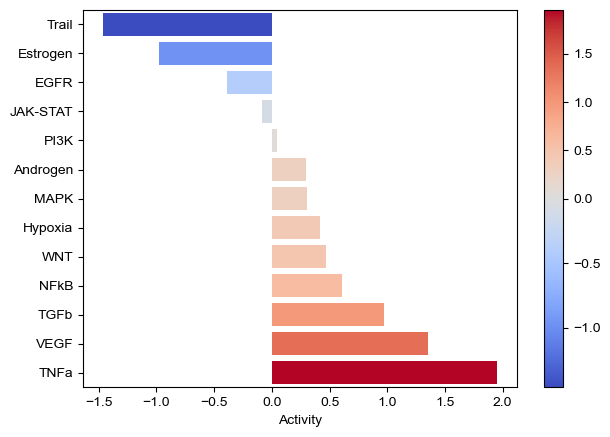

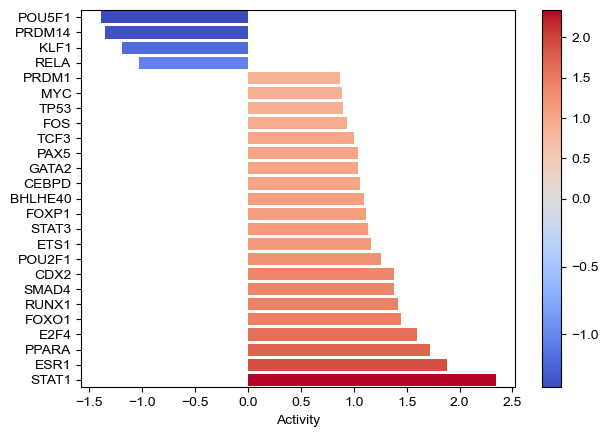

<Figure size 432x288 with 0 Axes>

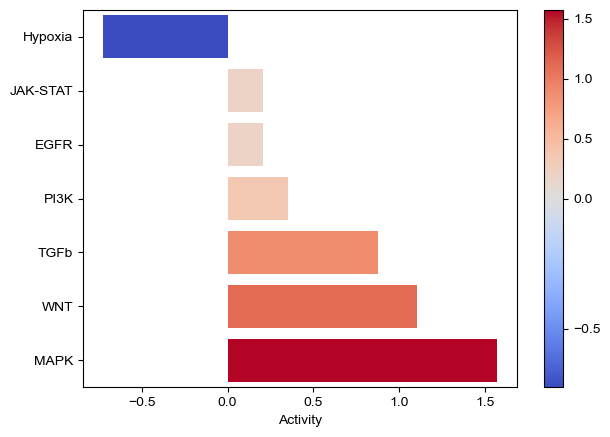

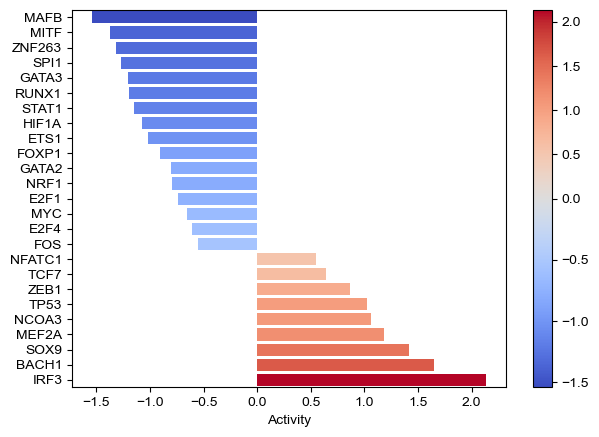

<Figure size 432x288 with 0 Axes>

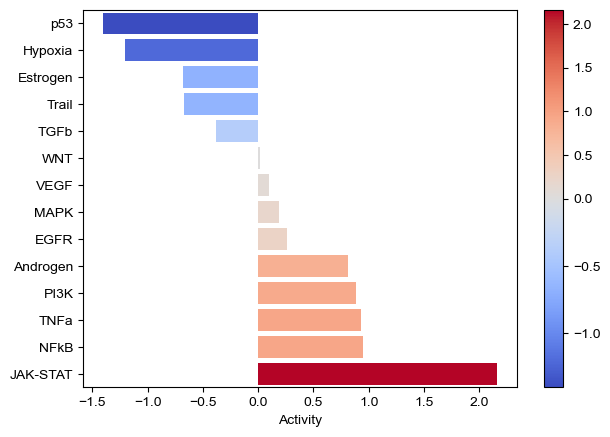

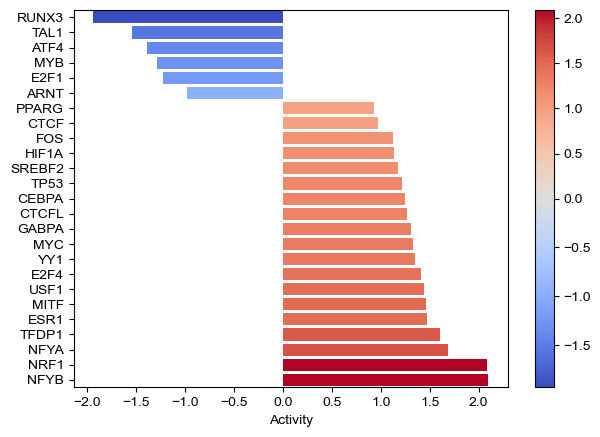

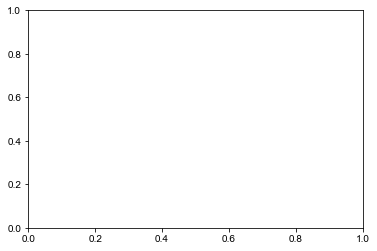

<Figure size 432x288 with 0 Axes>

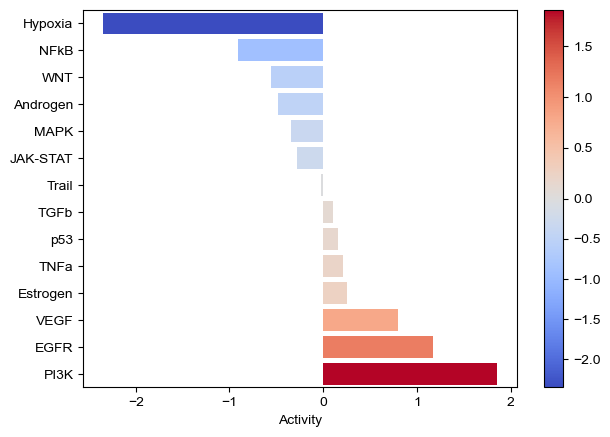

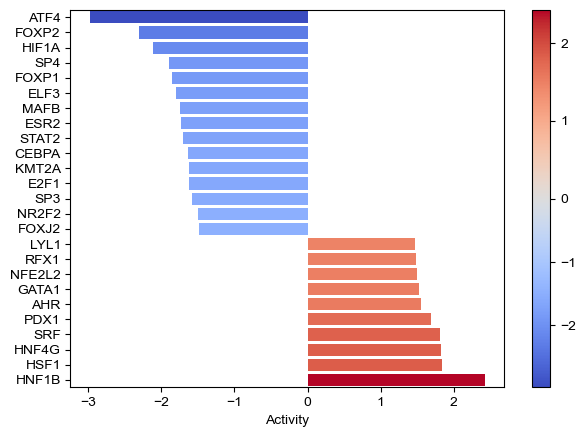

<Figure size 432x288 with 0 Axes>

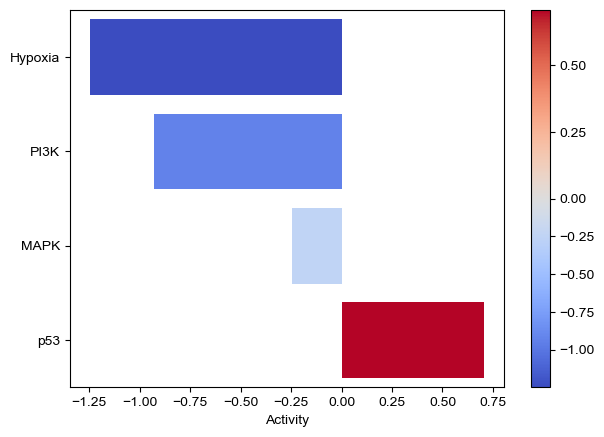

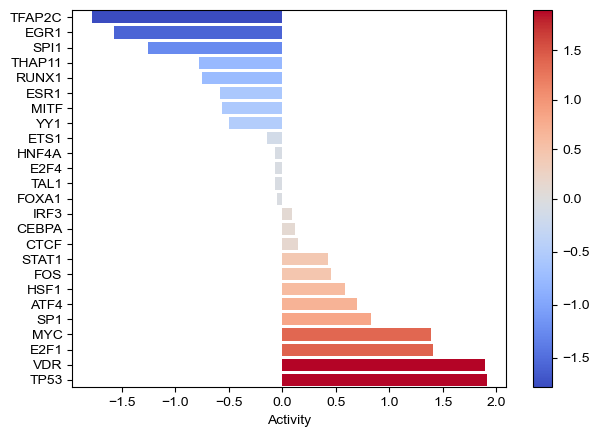

<Figure size 432x288 with 0 Axes>

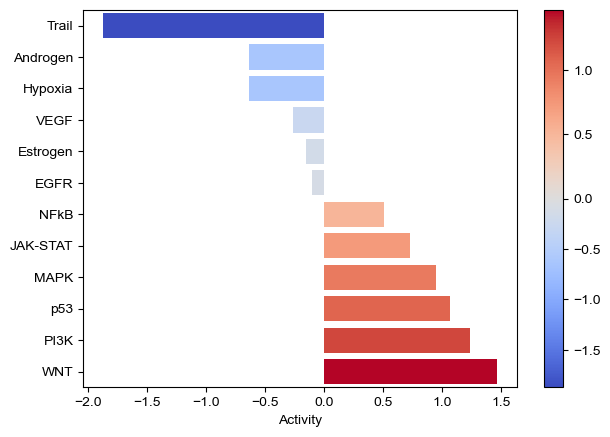

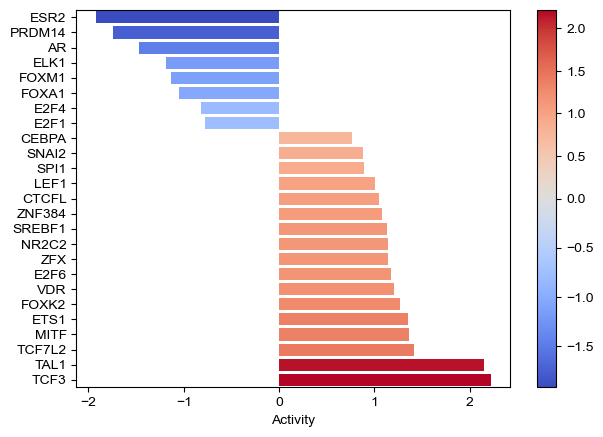

<Figure size 432x288 with 0 Axes>

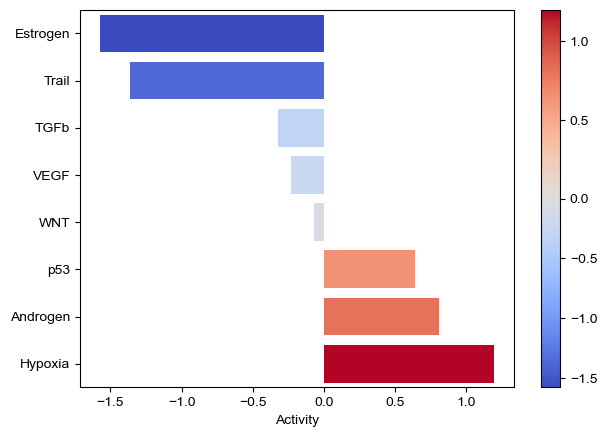

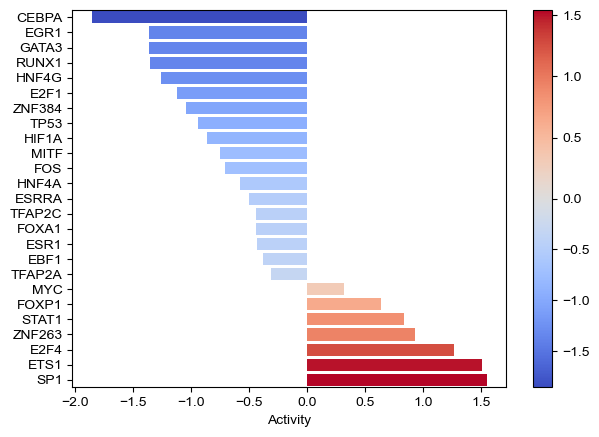

<Figure size 432x288 with 0 Axes>

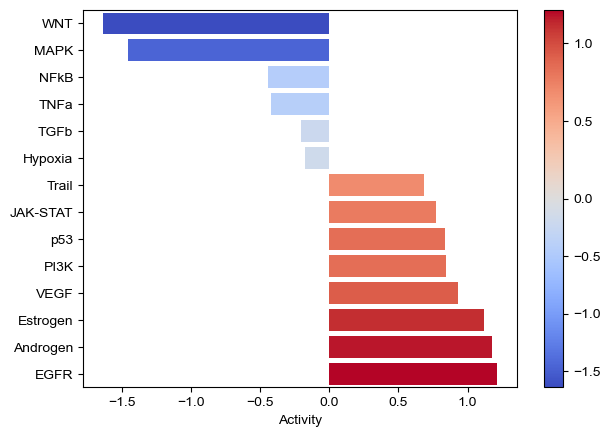

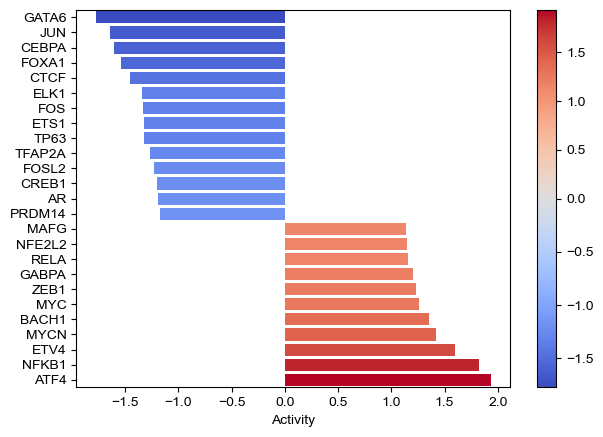

<Figure size 432x288 with 0 Axes>

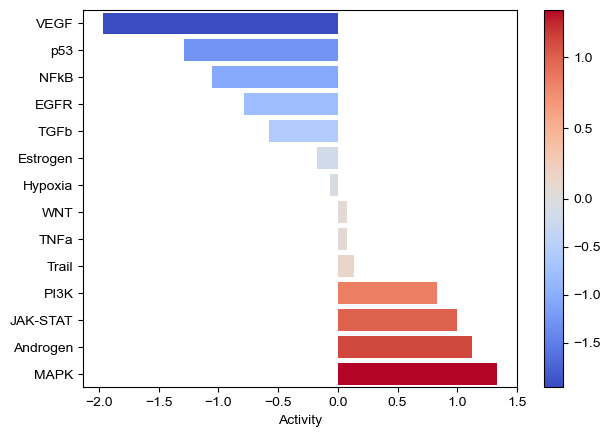

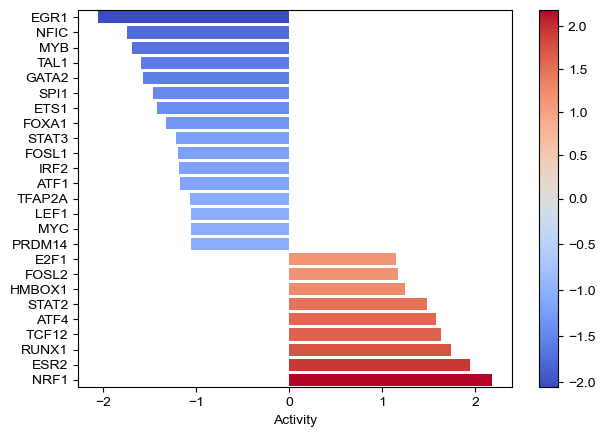

<Figure size 432x288 with 0 Axes>

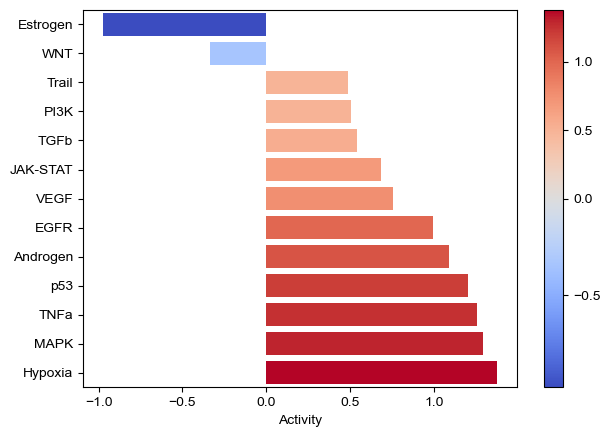

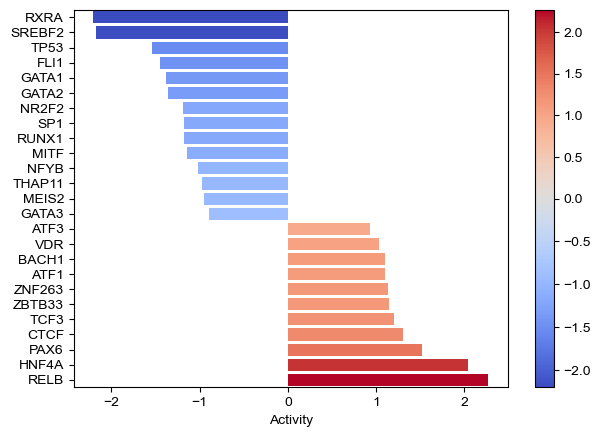

<Figure size 432x288 with 0 Axes>

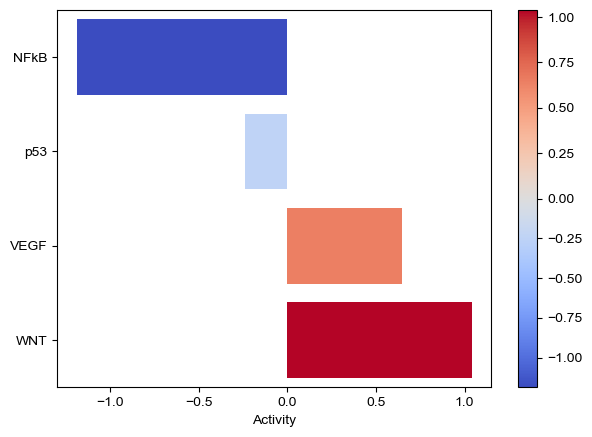

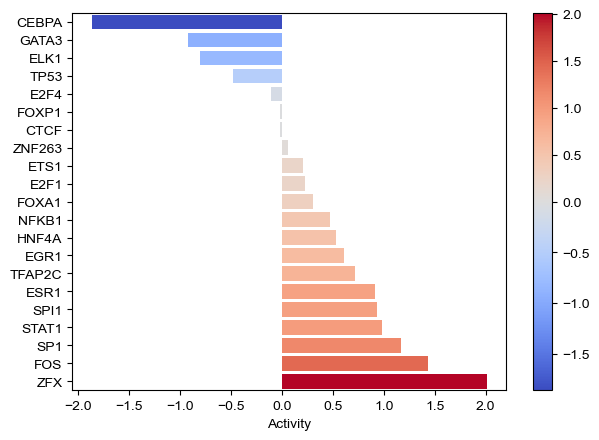

<Figure size 432x288 with 0 Axes>

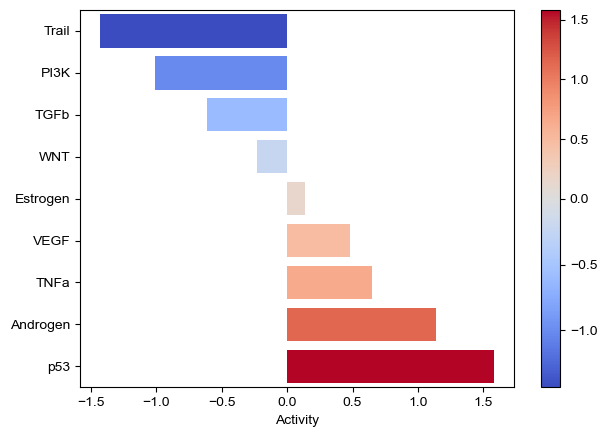

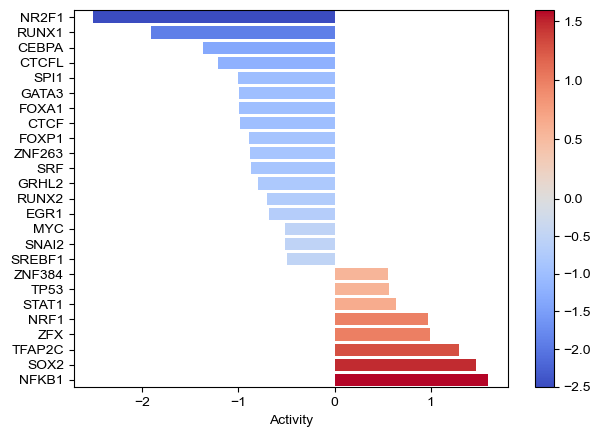

<Figure size 432x288 with 0 Axes>

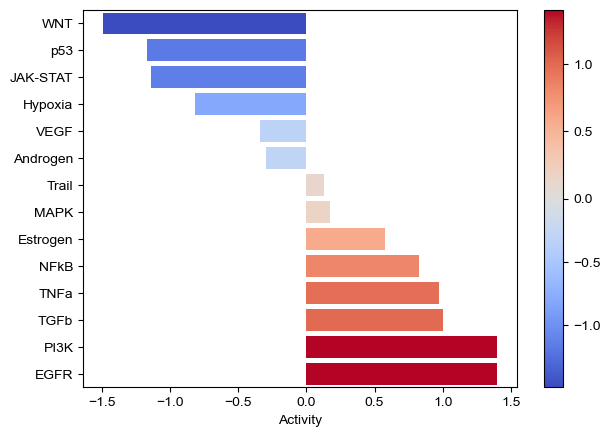

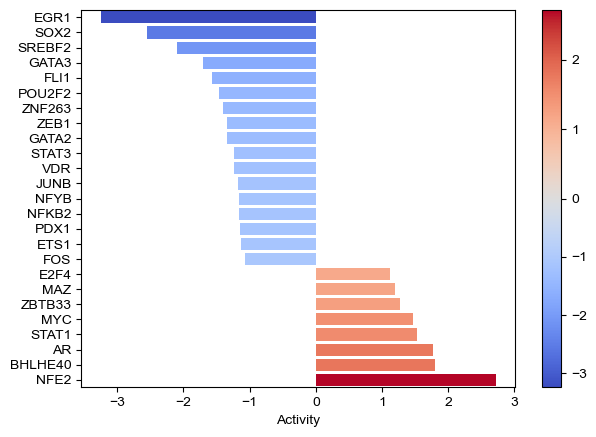

<Figure size 432x288 with 0 Axes>

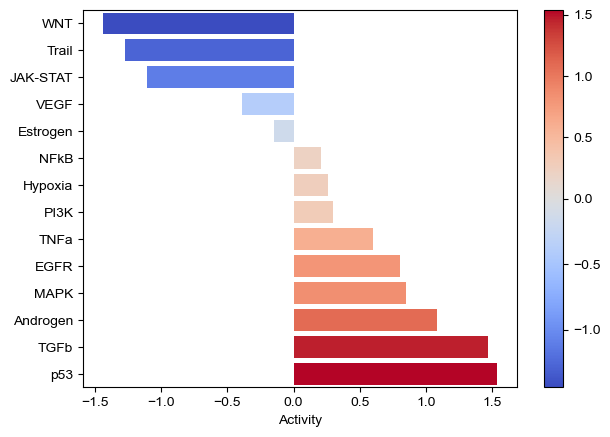

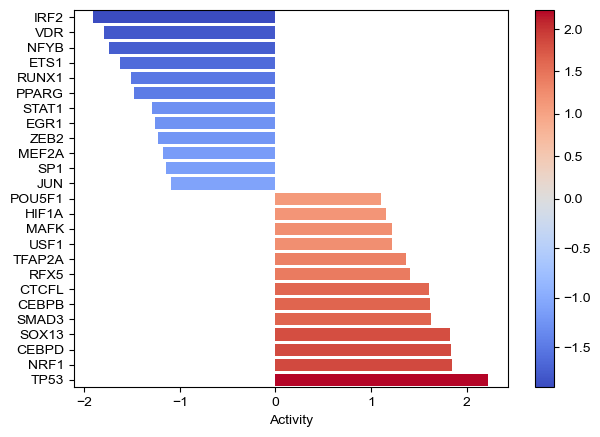

<Figure size 432x288 with 0 Axes>

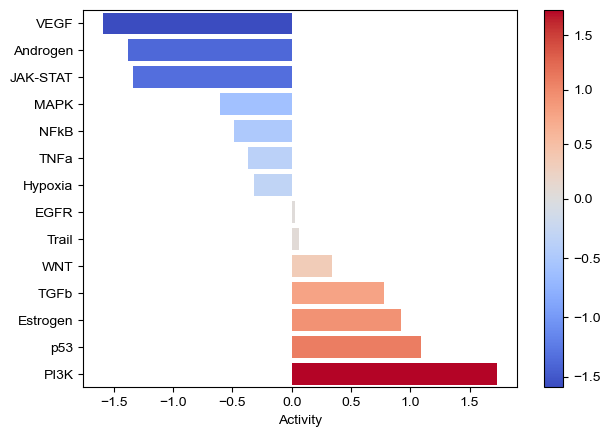

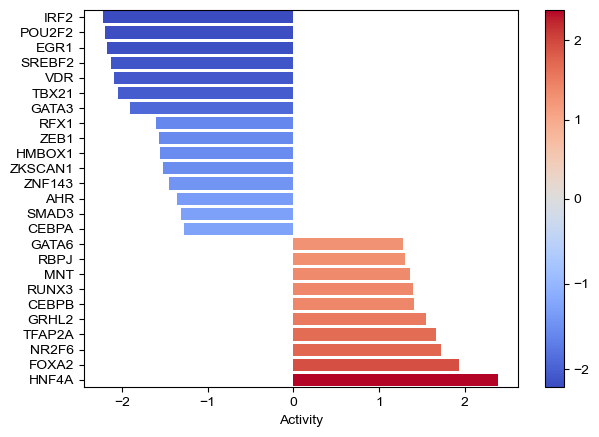

<Figure size 432x288 with 0 Axes>

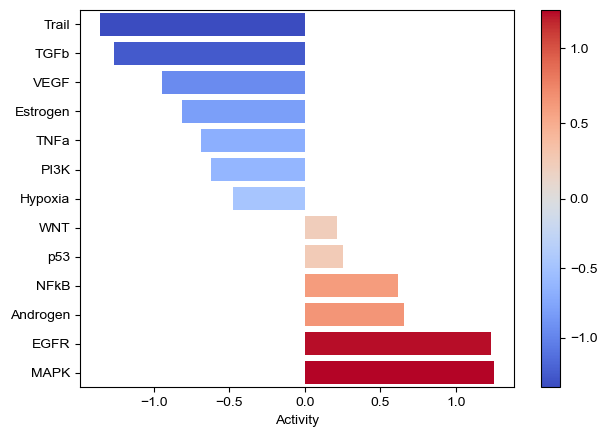

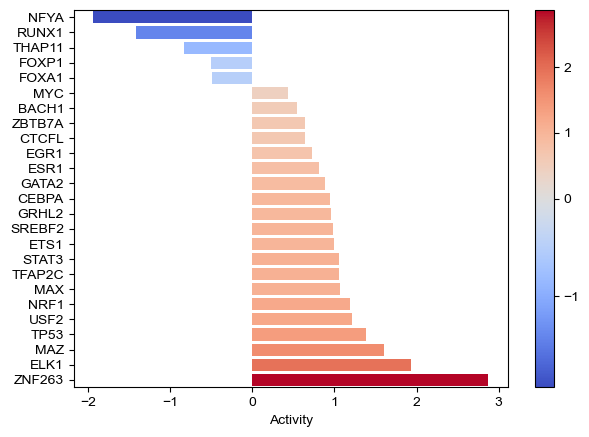

<Figure size 432x288 with 0 Axes>

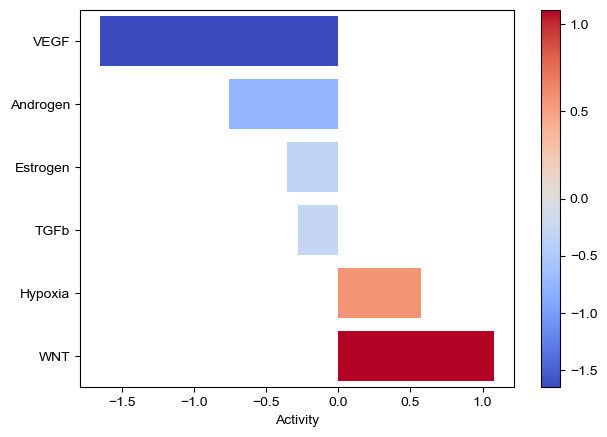

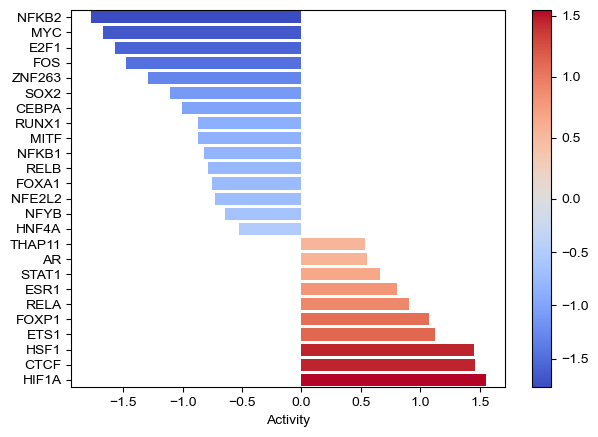

<Figure size 432x288 with 0 Axes>

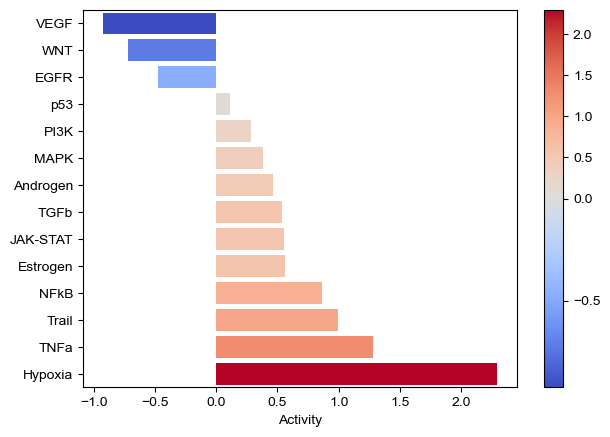

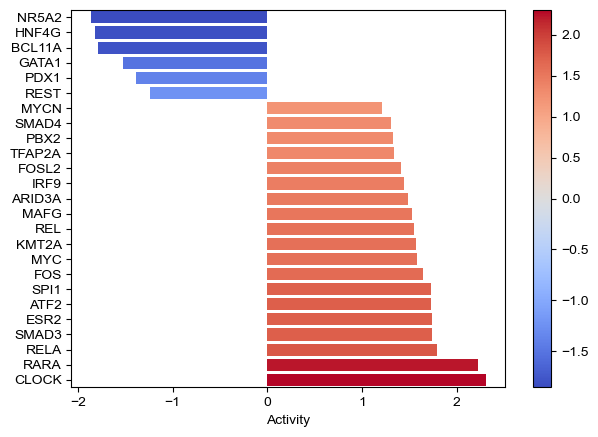

<Figure size 432x288 with 0 Axes>

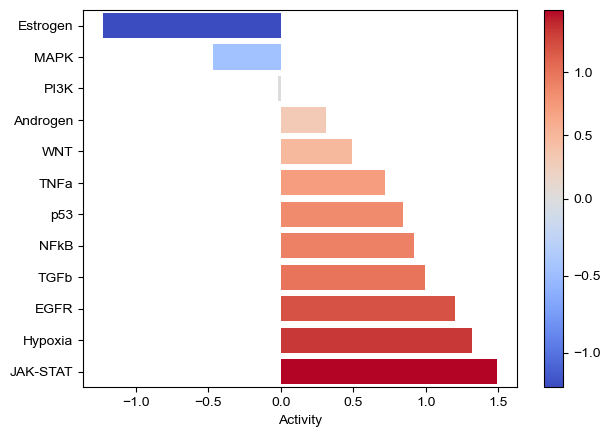

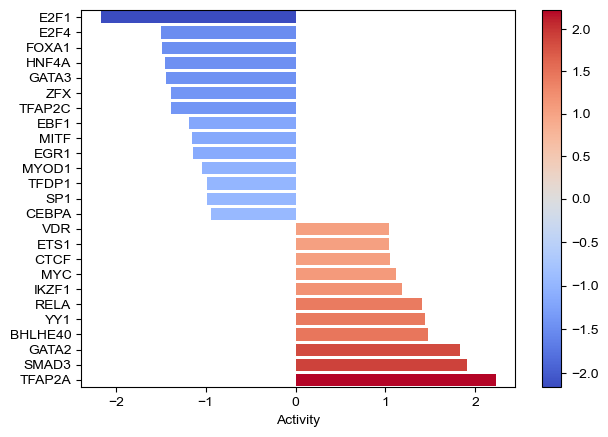

<Figure size 432x288 with 0 Axes>

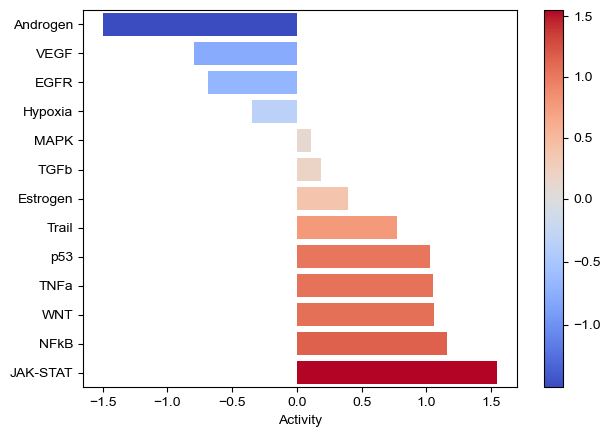

<Figure size 432x288 with 0 Axes>

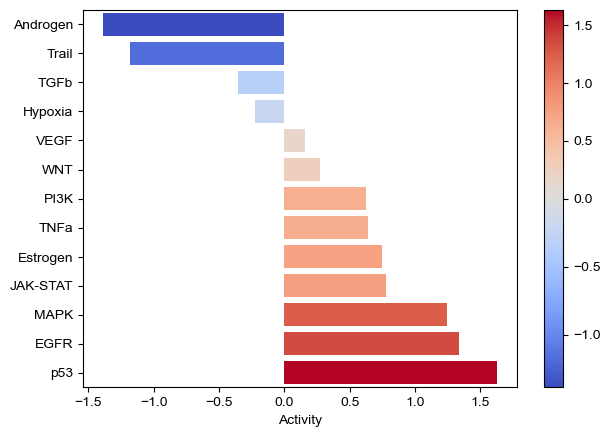

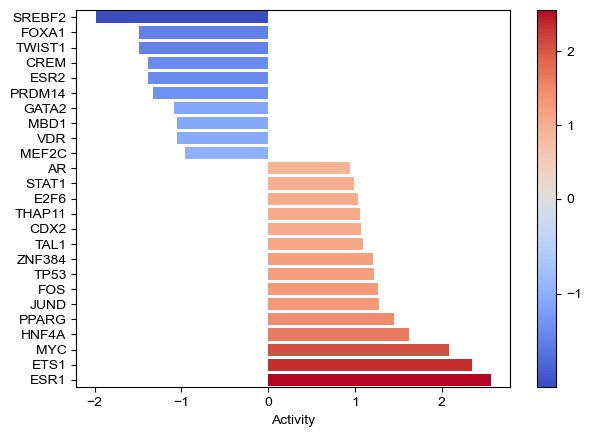

<Figure size 432x288 with 0 Axes>

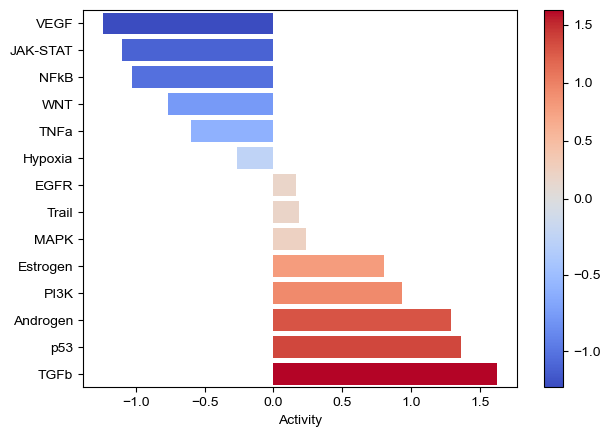

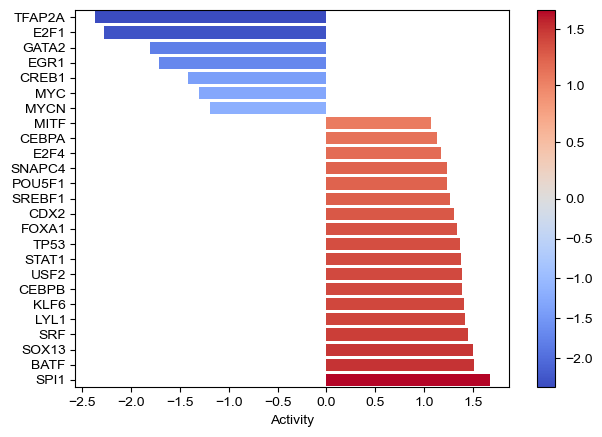

<Figure size 432x288 with 0 Axes>

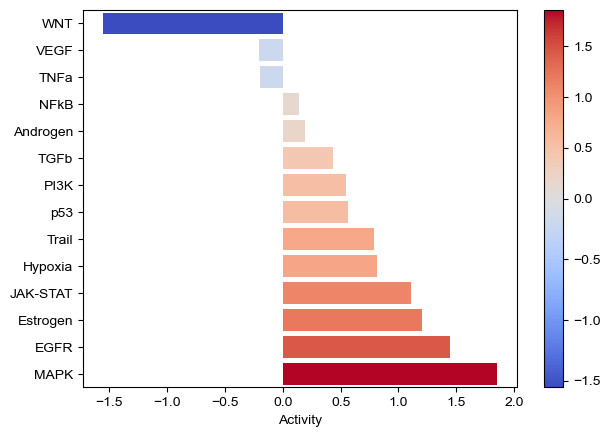

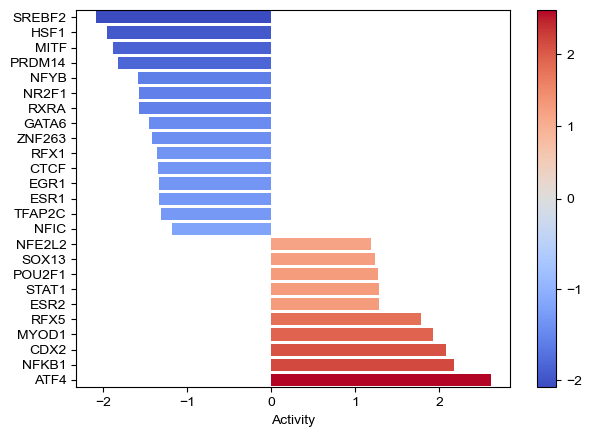

<Figure size 432x288 with 0 Axes>

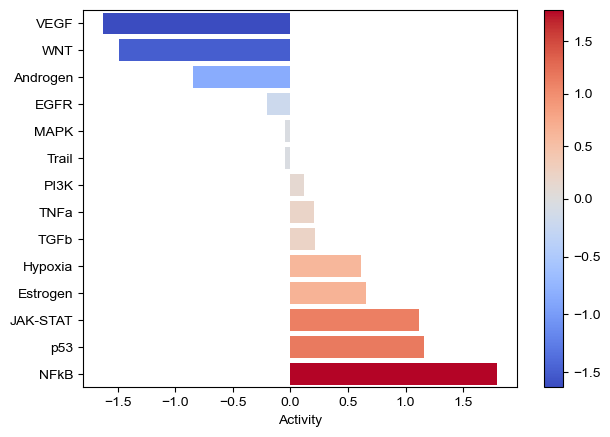

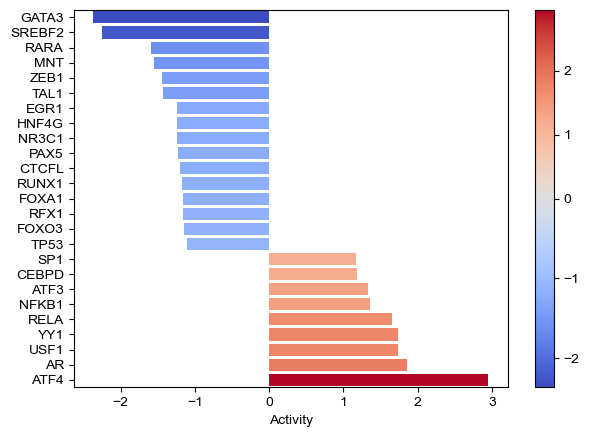

<Figure size 432x288 with 0 Axes>

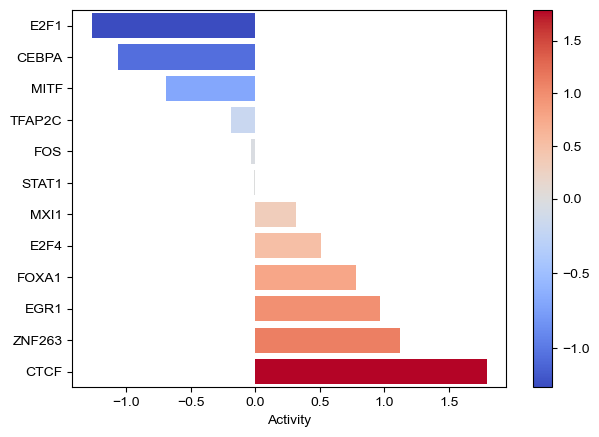

In [21]:
for drug in drug_genes.index.tolist():
    print(drug)
    fig, ax = plt.subplots()
    
    if drug in drug_pathways:
        if drug in drug_pathways:
            #plt.title(drug+ ' model importance pathways')
            dc.plot_barplot(drug_pathways[drug][0].dropna(axis = 1), 
                            drug, top=25, vertical=True, 
                                 return_fig=True, save = os.path.join(out_folder, 'pathways/'+drug+'_model_importance_pathways.png'))
            fig.clear()
    if drug in drug_tf:
        #plt.title(drug+ ' model importance transcription factor activity')
        dc.plot_barplot(drug_tf[drug][0].dropna(axis = 1), drug, top=25, vertical=True, return_fig=True,
                            save = os.path.join(out_folder, 'transcription_factor_activity/'+drug+'_model_importance_TF.png'))
        #fig.savefig(os.path.join(out_folder, 'transcription_factor_activity/'+drug+'_response_TF.png'))
        fig.clear()

In [102]:
def plot_cmap(data, pval, name, subf, figsize = (8,7), bbox = (0.02, 0.7), dratio = 0.2, 
              cratio = 0.03, lwidth_min = 0, title_y = -0.01):
    out = os.path.join(out_folder, subf)
    drug_matrix = pd.DataFrame()
        
    for drug in np.sort(chemo_drugs).tolist()+np.sort(target_drugs).tolist():
        if not drug in data: 
            drug_matrix = drug_matrix.append(pd.DataFrame(index = [drug]))
            continue
        vals = data[drug][0]
        vals.index = [drug]
        pvals = data[drug][1]
        pvals = pvals[pvals<0.05].dropna(axis = 1)
        if pval:
            vals = vals[pvals.columns]
        drug_matrix = drug_matrix.append(vals)
        
    colors = ['darkorange', 'tan']
    row_colors = [colors[0]] * len(chemo_drugs) + [colors[1]] * len(target_drugs)

    cm = sns.clustermap(drug_matrix.fillna(0), cmap='coolwarm', figsize = figsize, 
                        row_cluster = False, row_colors=row_colors, 
                        cbar_kws=dict(orientation='horizontal'), dendrogram_ratio=dratio, colors_ratio=cratio)
    x0, y0, _w, h = cm.cbar_pos
    cm.ax_cbar.set_position([x0, 0.85, cm.ax_row_dendrogram.get_position().width-lwidth_min, 0.02])
    cm.ax_cbar.set_title('Importance of\nhigh expr. level\nfor predicting \nresponders (red)/\nnon-responders (blue)', size=9)
    cm.ax_cbar.tick_params(axis='x', length=10)
    
    from matplotlib.patches import Patch
    handles = [Patch(facecolor=colors[0]), Patch(facecolor=colors[1])]
    plt.legend(handles, ['chemo', 'targeted'], title='Drugs',
               bbox_to_anchor=bbox, bbox_transform=plt.gcf().transFigure, loc='center left')

    if pval:
        cm.fig.suptitle(name+' based on SHAP values (pval < 0.05)', y = title_y)
        plt.savefig(os.path.join(out, subf+'_pval_filt.png'), bbox_inches="tight", facecolor = 'white', transparent = False, dpi=500) 
    else:
        cm.fig.suptitle(name+' based on SHAP values', y = title_y)
        plt.savefig(os.path.join(out, subf+'.png'), bbox_inches="tight", facecolor = 'white', transparent = False, dpi=500) 

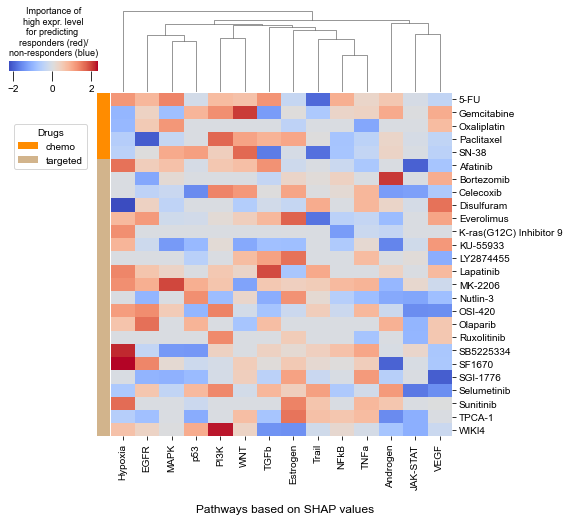

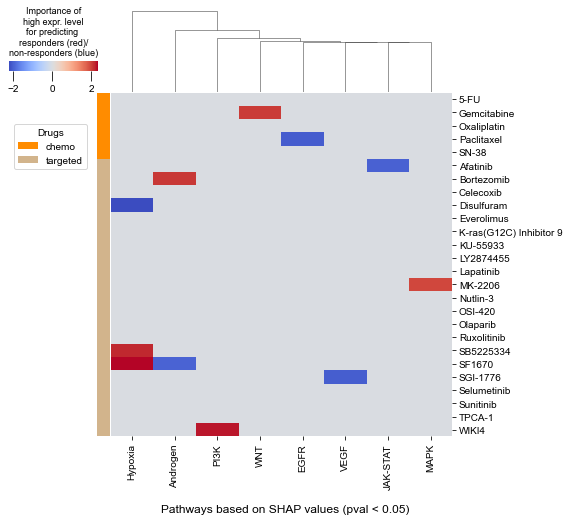

In [103]:
plot_cmap(drug_pathways, False, 'Pathways', 'pathways')
plot_cmap(drug_pathways, True, 'Pathways', 'pathways')

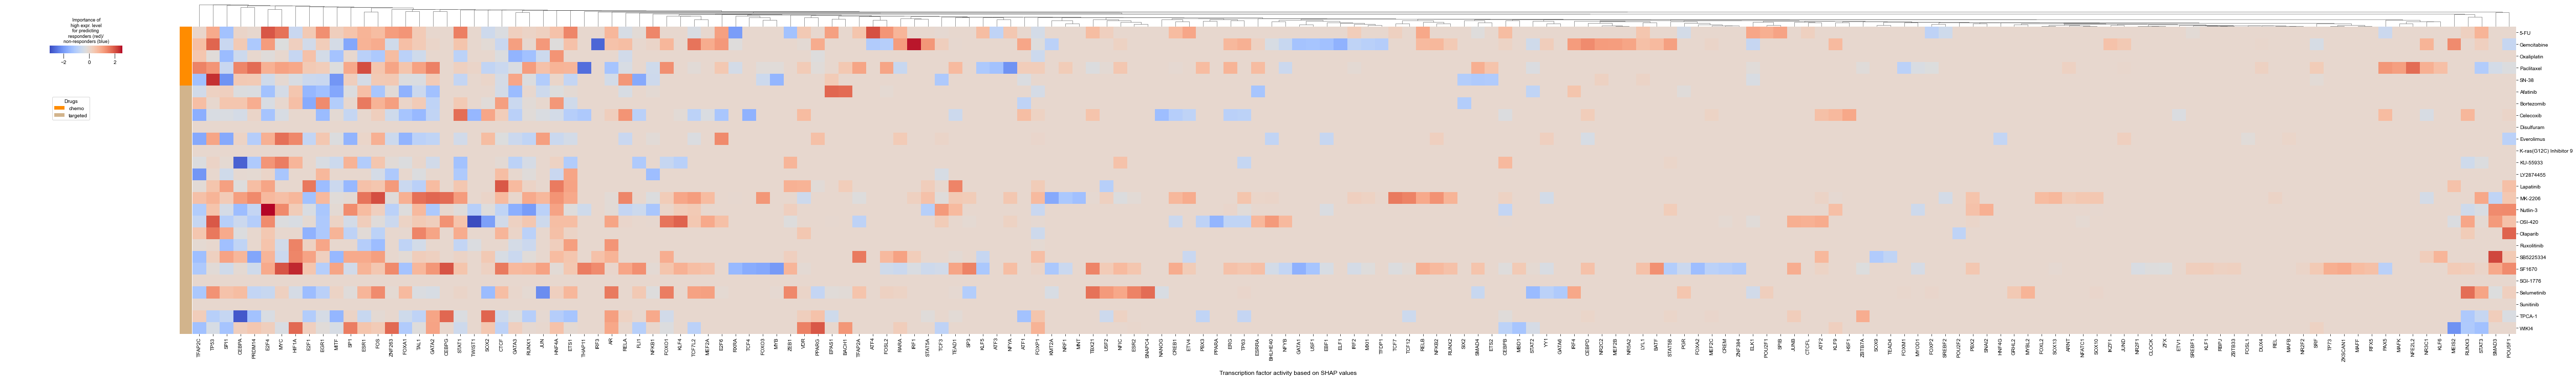

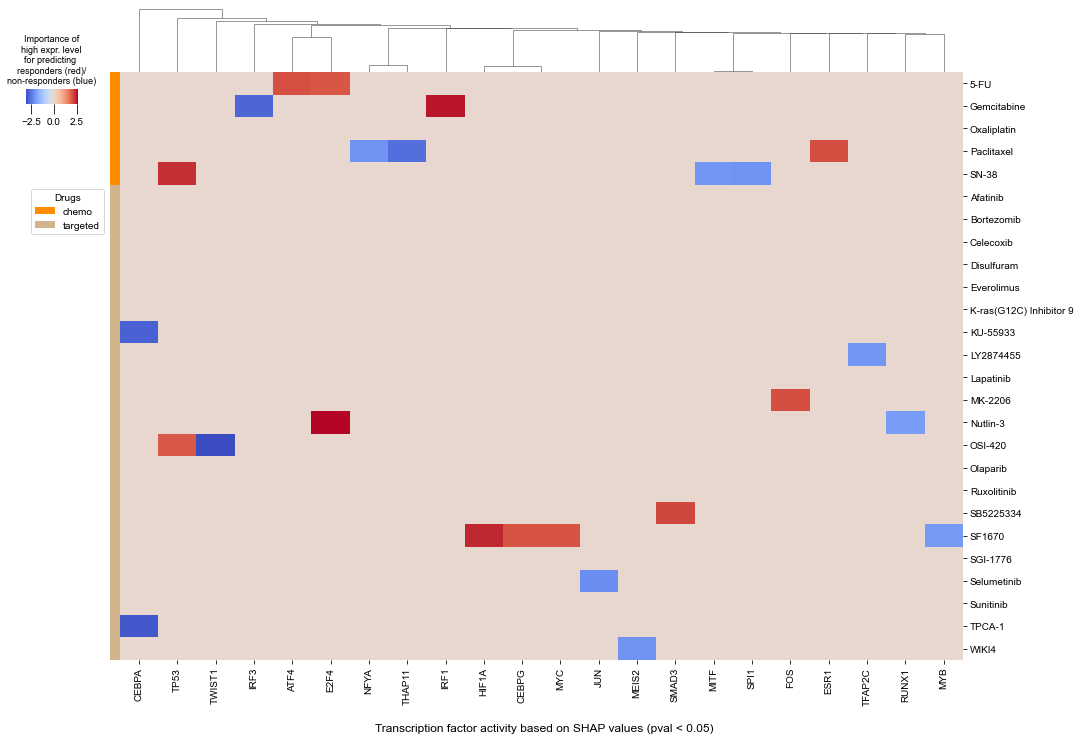

In [104]:
plot_cmap(drug_tf, False, 'Transcription factor activity', 'transcription_factor_activity', 
          figsize = (70,10), dratio = 0.07, cratio = 0.005, lwidth_min = 0.04)
plot_cmap(drug_tf, True, 'Transcription factor activity', 'transcription_factor_activity', 
          figsize = (15,10), dratio = 0.1, cratio = 0.01, lwidth_min = 0.04)

In [105]:
from matplotlib.backends.backend_pdf import PdfPages

def plot_pdf(data, pval, name, subf, figsize1 = (6, 3), figsize2 = (7, 7), dratio = 0.2, 
             lwidth_min = 0, title_y = -0.01):

    if pval:
        cm1_title = 'Chemo drugs: %s based\non SHAP values (pval < 0.05)' % name
        cm2_title = 'Targeted drugs: %s based on SHAP values (pval < 0.05)' % name
        outfile = os.path.join(out_folder, '%s/%s_pval_filt.pdf') % (subf, subf)
    else:
        cm1_title = 'Chemo drugs: %s based on SHAP values' % name
        cm2_title = 'Targeted drugs: %s based on SHAP values' % name
        outfile = os.path.join(out_folder, '%s/%s.pdf') % (subf, subf)

    pdf = PdfPages(outfile)

    drug_matrix = pd.DataFrame()
    for drug in np.sort(chemo_drugs):
        if not drug in data: 
            drug_matrix = drug_matrix.append(pd.DataFrame(index = [drug]))
            continue
        vals = data[drug][0]
        vals.index = [drug]
        pvals = data[drug][1]
        pvals = pvals[pvals<0.05].dropna(axis = 1)
        if pval:
            vals = vals[pvals.columns]
        drug_matrix = drug_matrix.append(vals)

    cm1 = sns.clustermap(drug_matrix.fillna(0), cmap='coolwarm', cbar_kws=dict(orientation='horizontal'),
                         figsize = figsize1, dendrogram_ratio=dratio)
    x0, y0, _w, h = cm1.cbar_pos
    cm1.ax_cbar.set_position([x0, 0.87, cm1.ax_row_dendrogram.get_position().width-lwidth_min, 0.02])
    cm1.ax_cbar.set_title('Importance of\nhigh expr. level\nfor predicting \nresponders (red)/\nnon-responders (blue)', size=9)
    cm1.ax_cbar.tick_params(axis='x')
    cm1.fig.suptitle(cm1_title, y = -0.01)

    pdf.savefig(bbox_inches="tight")
    plt.show()
    plt.close()

    drug_matrix = pd.DataFrame()
    for drug in np.sort(target_drugs):
        if not drug in data: 
            drug_matrix = drug_matrix.append(pd.DataFrame(index = [drug]))
            continue
        vals = data[drug][0]
        vals.index = [drug]
        pvals = data[drug][1]
        pvals = pvals[pvals<0.05].dropna(axis = 1)
        if pval:
            vals = vals[pvals.columns]
        drug_matrix = drug_matrix.append(vals)

    cm2 = sns.clustermap(drug_matrix.fillna(0), cmap='coolwarm', cbar_kws=dict(orientation='horizontal'),
                         figsize = figsize2, dendrogram_ratio=dratio)
    x0, y0, _w, h = cm2.cbar_pos
    cm2.ax_cbar.set_position([x0, 0.87, cm1.ax_row_dendrogram.get_position().width-lwidth_min, 0.02])
    cm2.ax_cbar.set_title('Importance of\nhigh expr. level\nfor predicting \nresponders (red)/\nnon-responders (blue)', 
                          size=9)
    cm2.ax_cbar.tick_params(axis='x')
    cm2.fig.suptitle(cm2_title, y = -0.01)

    pdf.savefig(bbox_inches="tight")
    plt.show()
    plt.close()  
    pdf.close()

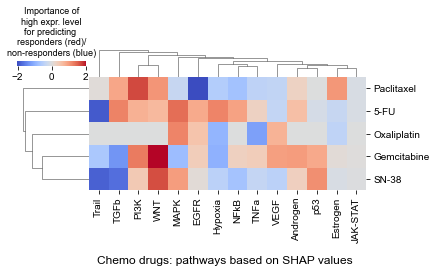

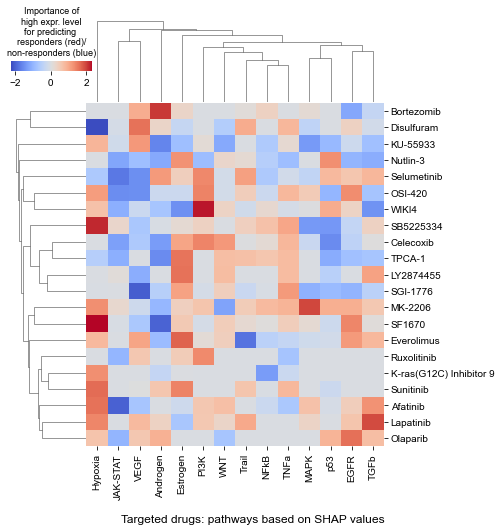

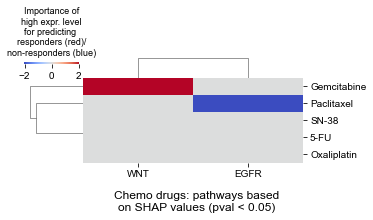

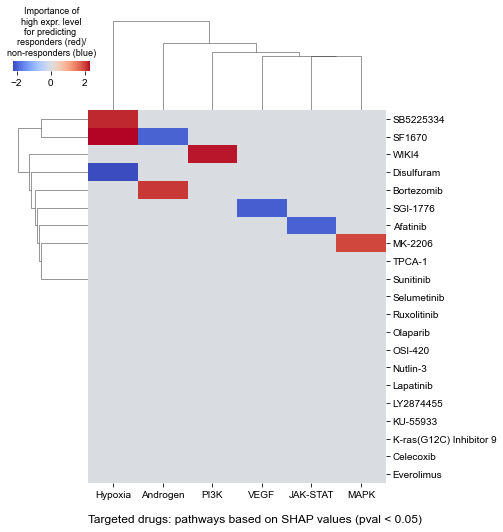

In [106]:
plot_pdf(drug_pathways, False, 'pathways', 'pathways')
plot_pdf(drug_pathways, True, 'pathways', 'pathways', figsize1 = (5,2))

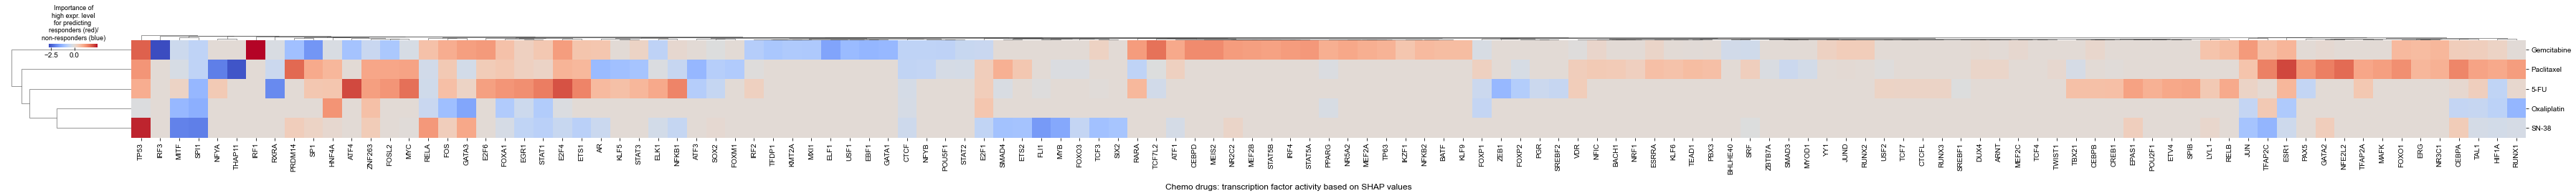

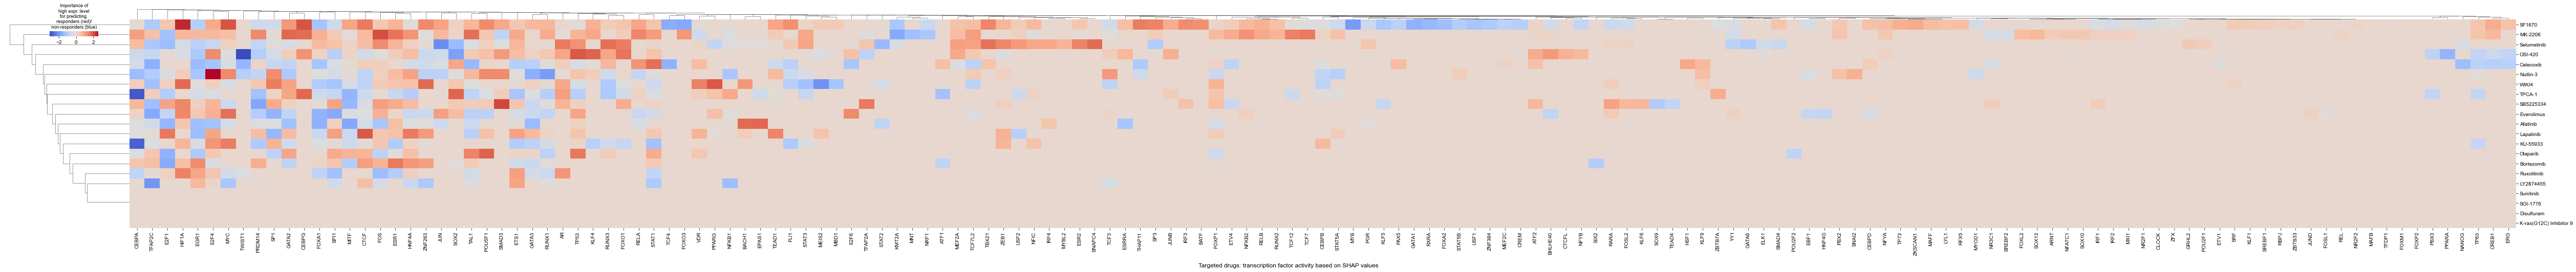

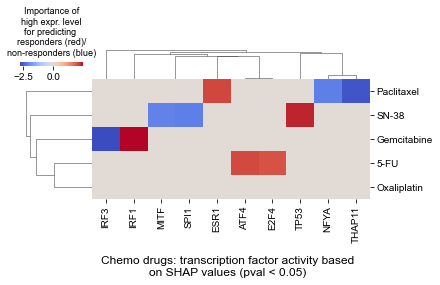

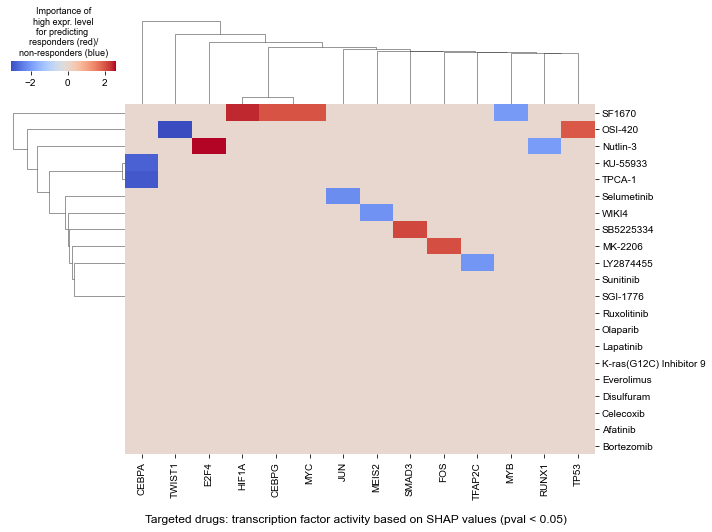

In [107]:
plot_pdf(drug_tf, False, 'transcription factor activity', 'transcription_factor_activity',
         figsize1 = (50,3), figsize2 = (70, 7), dratio = 0.05, lwidth_min = 0.03)
plot_pdf(drug_tf, True, 'transcription factor activity', 'transcription_factor_activity', 
         figsize1 = (6,3), figsize2 = (10, 7), dratio = 0.2, lwidth_min = 0.015)

In [96]:
important_features = pd.read_csv('feature_importance/Pancreatic/AUC_zscore/feature_scores_pan.csv', index_col = 0)
important_features_dict = {}
for drug, df in important_features.groupby('drug'):
    important_features_dict[drug] = df
    
model_genes = {}
for drug, df in important_genes.groupby('drug'):
    model_genes[drug] = df.set_index('gene').drop(columns = 'drug')
    
DEA_top_genes = {}
for drug in drug_genes.index.tolist():
    DEA_top_genes[drug] = pd.read_excel('feature_importance/Pancreatic/DEA/top_genes_DEA.xlsx', sheet_name=drug, index_col=0)

In [97]:
import scipy
compare_df = pd.DataFrame(index = drug_genes.index.tolist(), columns = ["DEA vs Pearson's R", "DEA vs SHAP", "SHAP vs Pearson's R"])
for drug in chemo_drugs+target_drugs:
    shap_genes = model_genes[drug] * -1
    corr_genes = important_features_dict[drug] * -1
    dea_genes = DEA_top_genes[drug]
    
    shap_corr = shap_genes.join(corr_genes).dropna()
    dea_corr = dea_genes.join(corr_genes).dropna()
    dea_shap = dea_genes.join(shap_genes).dropna()
    
    print(drug, len(dea_corr), len(dea_shap))
    
    p_dea_corr = scipy.stats.pearsonr(dea_corr.logFCs, dea_corr['pearson'])
    if len(dea_shap)<2:
        p_dea_shap = (0,0)
    else: p_dea_shap = scipy.stats.pearsonr(dea_shap.logFCs, dea_shap['shap'])
    p_shap_corr = scipy.stats.pearsonr(shap_corr['shap'], shap_corr['pearson'])

    compare_df.loc[drug] = [p_dea_corr[0], p_dea_shap[0], p_shap_corr[0]]
compare_df.sort_values(by = 'DEA vs SHAP')

Gemcitabine 732 67
Paclitaxel 566 60
SN-38 456 37
5-FU 301 34
Oxaliplatin 262 15
Celecoxib 152 15
SB5225334 448 29
Everolimus 593 32
TPCA-1 123 11
Disulfuram 690 30
WIKI4 331 30
Bortezomib 293 14
Ruxolitinib 227 18
Lapatinib 195 14
SF1670 244 24
LY2874455 113 7
K-ras(G12C) Inhibitor 9 321 7
Selumetinib 350 45
OSI-420 343 35
Nutlin-3 231 24
KU-55933 404 23
Sunitinib 185 7
Olaparib 173 11
MK-2206 272 27
Afatinib 631 45
SGI-1776 82 10


,DEA vs Pearson's R,DEA vs SHAP,SHAP vs Pearson's R
Sunitinib,0.868967,-0.704817,0.615898
LY2874455,0.893914,0.104402,0.759415
SB5225334,0.909587,0.457003,0.757036
Everolimus,0.940251,0.598306,0.790775
Afatinib,0.932037,0.624573,0.774603
WIKI4,0.911284,0.659083,0.786088
Disulfuram,0.920205,0.67328,0.753201
Oxaliplatin,0.921006,0.67798,0.725296
Paclitaxel,0.909585,0.698723,0.826497
TPCA-1,0.862538,0.72544,0.810962
